Stop running spark context

In [4]:
sc.stop()

Load libraries

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 200)
from datasets import get_pyspark_titanic, get_sklearn_titanic
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from deepchecks.suites import full_suite
from deepchecks import Dataset

seed=0

22/10/30 15:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/30 15:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/30 15:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/30 15:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
2022-10-30 15:52:31,013 [138331] WARNING  py.warnings:109: [JupyterRequire] /home/haftamu/.local/lib/python3.8/site-packages/deepchecks/suites.py:21: DeprecationWarning:

Ability to import tabular suites from the `deepchecks.suites` is deprecated, please import from `deepchecks.tabular.suites` instead


2022-10-30 15:52:31,016 [138331] WARNING  py.warnings:109: [JupyterRequire] /home/haftamu/.local/lib/python3.8/site-packages/deepchecks/__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepch

Array to store various models

In [6]:
models = ["LinearSVC", "Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes", "Gradient Boosting", "MLP Classifier", "One vs Rest", "Keras Network"]

**Train Test split**
* Read the data using the helper functions from the dataset.py file
    * get_sklearn_titanic() to read Titanic data for scikit-learn models
    * get_pyspark_titanic() to read titanic data for PySpark models
* Split the data into four numpy arrays for scikit-Learn and train test for the pyspark models
    * x_train, x_test, y_train, y_test
    * Train and test 

In [7]:
x_train, x_test, y_train, y_test = get_sklearn_titanic()
train, test = get_pyspark_titanic()

* Load scikit-learn classifiers 
* Train the various models with their default parameters  
* Evaluate the models using various metrics
* Visualize the performance scores for the various models 

In [8]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay



sklearn_classifiers = [
    LinearSVC(random_state=seed),
    LogisticRegression(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    GaussianNB(),
    GradientBoostingClassifier(random_state=seed),
    MLPClassifier(random_state=seed),
    OneVsRestClassifier(LinearSVC())
]

sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    sklearn_accuracy.append(clf.score(x_test, y_test))
    sklearn_confusion.append(confusion_matrix(clf.predict(x_test), y_test))
    sklearn_roc.append(roc_auc_score(y_test, clf.predict(x_test)))
    sklearn_precision.append(precision_score(y_test, clf.predict(x_test)))
    sklearn_recall.append(recall_score(y_test, clf.predict(x_test)))

* Load PySpark classifiers  
* Train the various models with their default parameters  
* Evaluate the models using various metrics
* Visualize the performance scores for the various models 

In [9]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest


pyspark_classifiers = [
    LinearSVC(labelCol="label"),
    LogisticRegression(labelCol="label"),
    DecisionTreeClassifier(labelCol="label", seed=seed),
    RandomForestClassifier(labelCol = 'label', seed=seed),
    NaiveBayes(labelCol = 'label', modelType="gaussian"),
    GBTClassifier(labelCol = 'label', seed=seed),
    MultilayerPerceptronClassifier(labelCol = 'label', seed=seed, layers=[len(test.toPandas()["features"][0]),100,]),
    OneVsRest(labelCol = 'label', classifier=LinearSVC())
]

pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
for clf in pyspark_classifiers:
    clf = clf.fit(train) # train the model 
    evaluator=MulticlassClassificationEvaluator(metricName="accuracy") # set the evaluation metric
    pyspark_accuracy.append(evaluator.evaluate(clf.transform(test))) # Predict on the test data
    pyspark_confusion.append(confusion_matrix(clf.transform(test).select("prediction").collect(), \
                      clf.transform(test).select("label").collect()))
    pyspark_roc.append(roc_auc_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))
    pyspark_precision.append(precision_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))
    pyspark_recall.append(recall_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))

22/10/30 15:55:21 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/30 15:55:21 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/30 15:56:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/30 15:56:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/10/30 15:56:54 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


Train Keras network classifier  

In [11]:
import tensorflow.keras as keras

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train)
sklearn_accuracy.append(clf.evaluate(x_test, y_test)[1])
sklearn_confusion.append(confusion_matrix(np.round(clf.predict(x_test)), y_test))
sklearn_roc.append(roc_auc_score(y_test, np.round(clf.predict(x_test))))
sklearn_precision.append(precision_score(y_test, np.round(clf.predict(x_test))))
sklearn_recall.append(recall_score(y_test, np.round(clf.predict(x_test))))
pyspark_accuracy.append(clf.evaluate(x_test, y_test)[1])
pyspark_confusion.append(confusion_matrix(np.round(clf.predict(x_test)), y_test))
pyspark_roc.append(roc_auc_score(y_test, np.round(clf.predict(x_test))))
pyspark_precision.append(precision_score(y_test, np.round(clf.predict(x_test))))
pyspark_recall.append(recall_score(y_test, np.round(clf.predict(x_test))))

2022-10-30 15:57:51.145645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-30 15:57:51.145681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-30 15:57:55.532157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-30 15:57:55.532197: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-30 15:57:55.532229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Haftamu-YOGA): /proc/driver/nvidia/version does not exist
2022-10-30 15:57:55.532959: I tensorflow/core/platform/cpu_featu

4/4 [==============================] - 0s 3ms/step


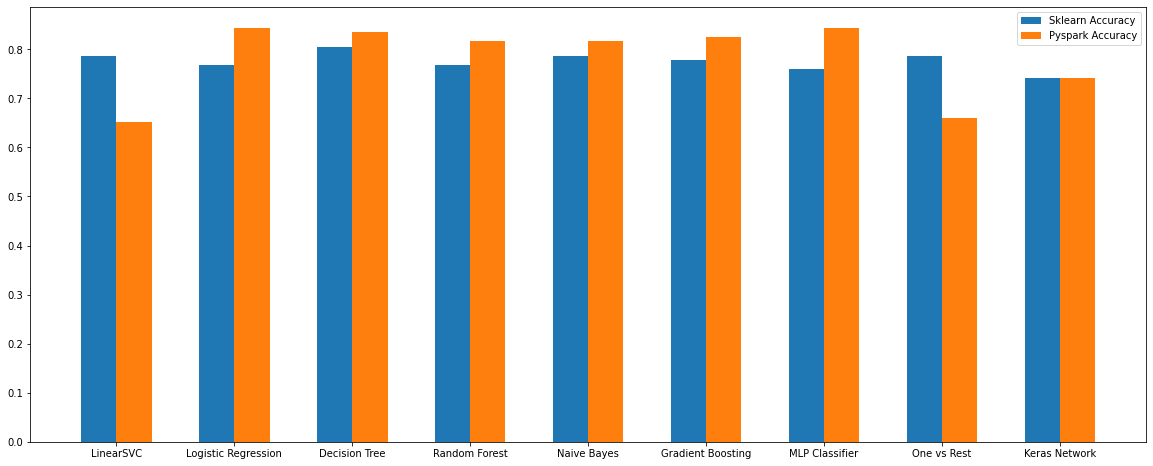

In [12]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_accuracy, align="edge", width=-0.3)
plt.bar(models, pyspark_accuracy, align="edge", width=0.3)
plt.legend(["Sklearn Accuracy", "Pyspark Accuracy"])

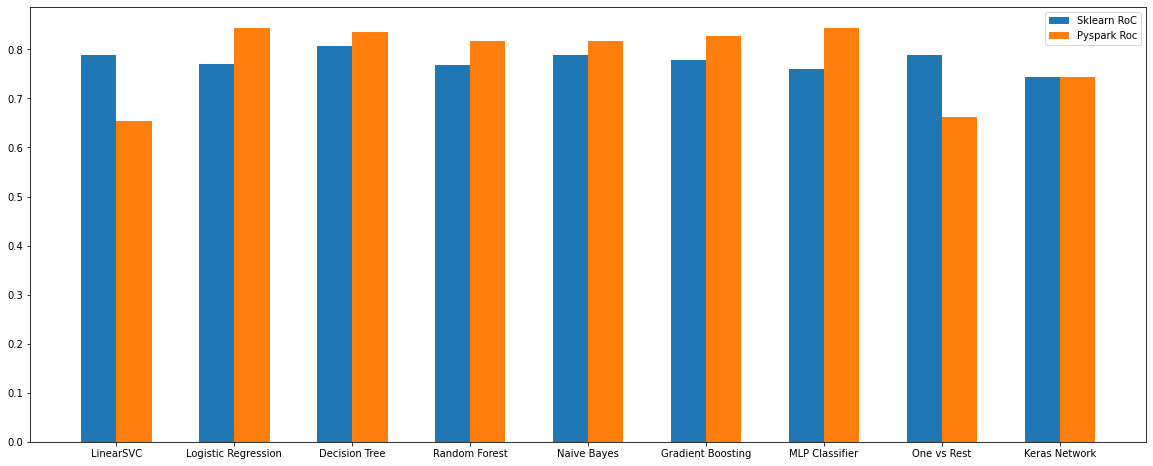

In [16]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_roc, align="edge", width=-0.3)
plt.bar(models, pyspark_roc, align="edge", width=0.3)
plt.legend(["Sklearn RoC", "Pyspark Roc"])

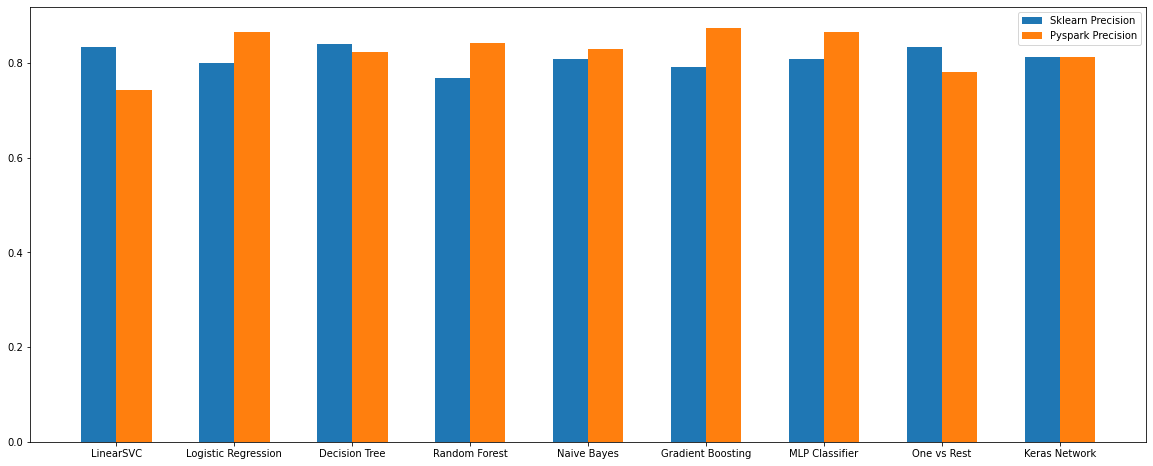

In [17]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_precision, align="edge", width=-0.3)
plt.bar(models, pyspark_precision, align="edge", width=0.3)
plt.legend(["Sklearn Precision", "Pyspark Precision"])

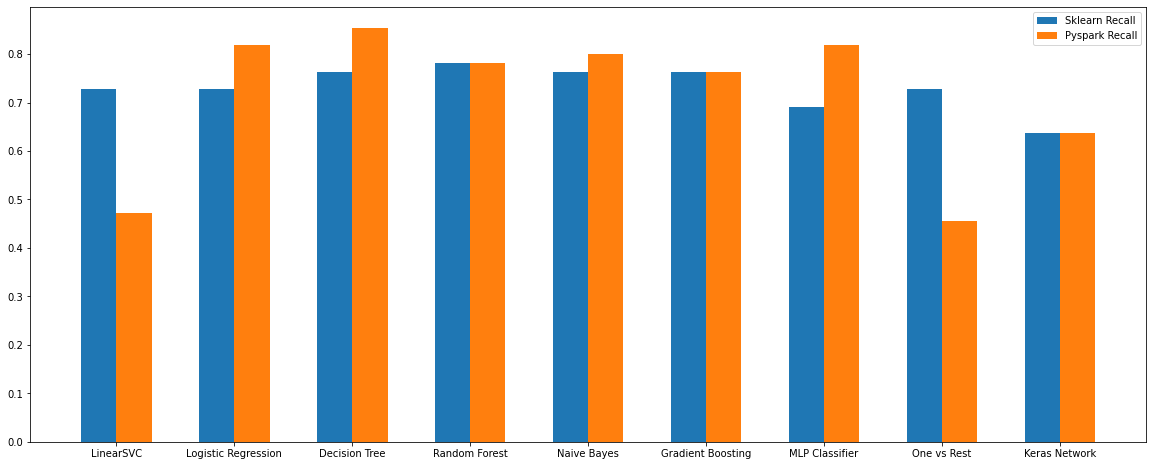

In [18]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_recall, align="edge", width=-0.3)
plt.bar(models, pyspark_recall, align="edge", width=0.3)
plt.legend(["Sklearn Recall", "Pyspark Recall"])

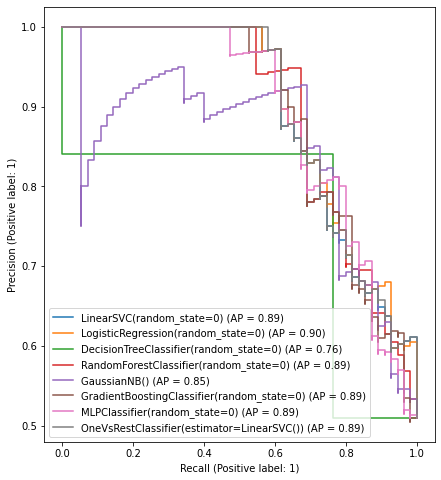

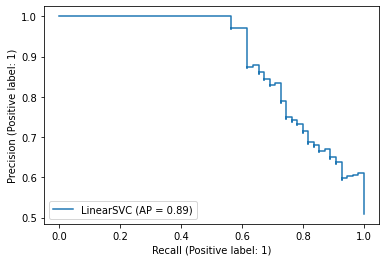

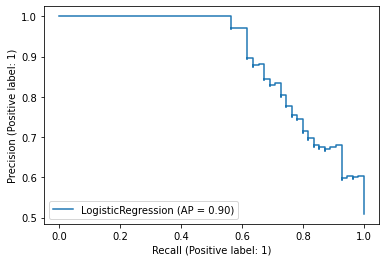

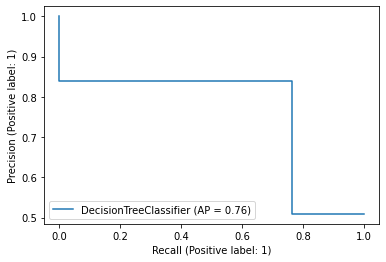

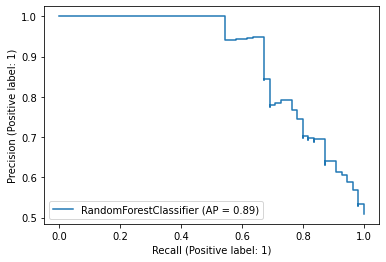

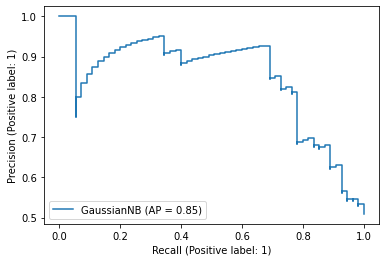

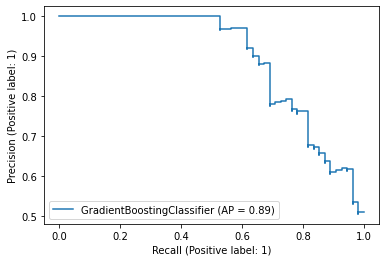

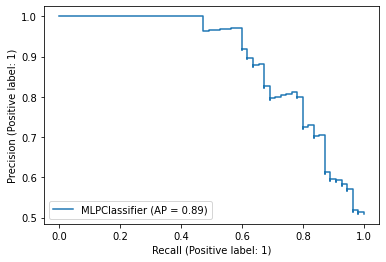

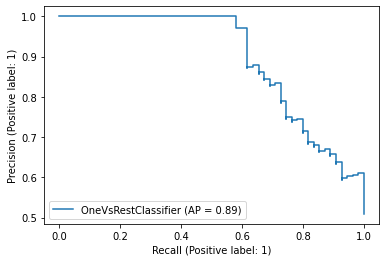

In [19]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)

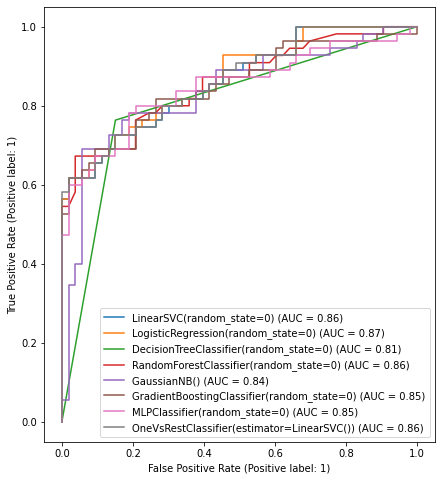

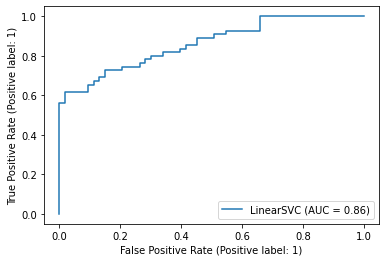

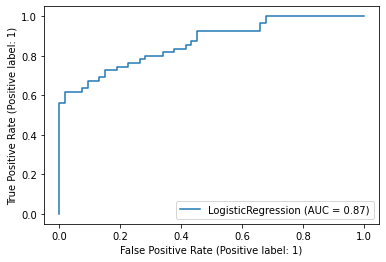

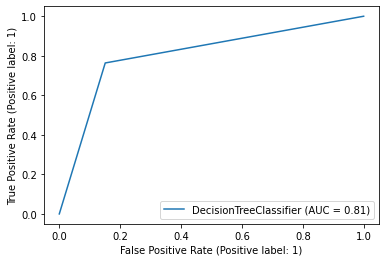

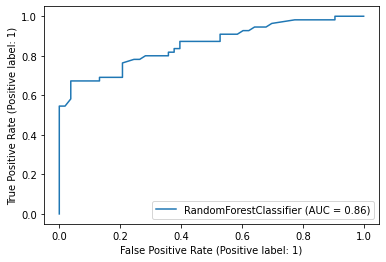

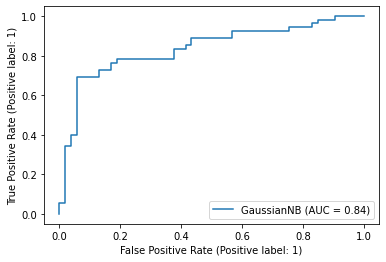

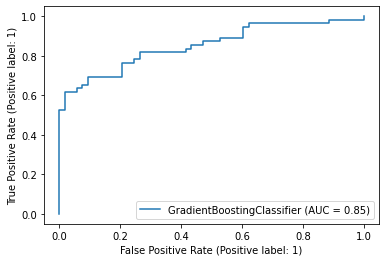

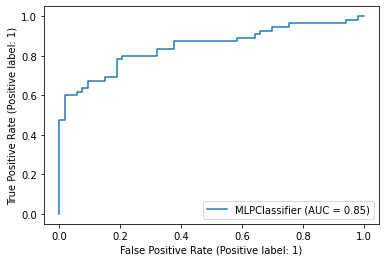

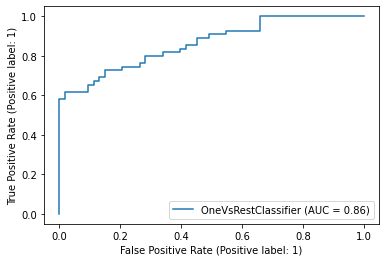

In [23]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)

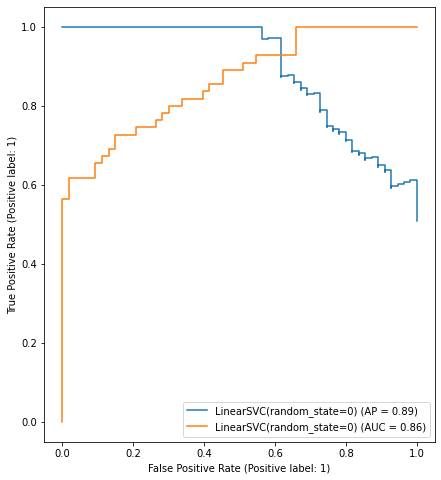

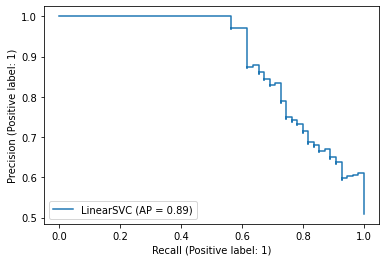

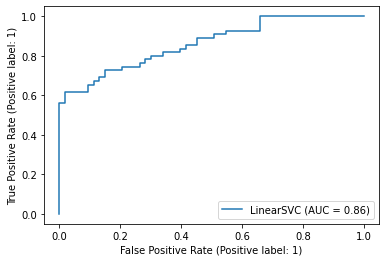

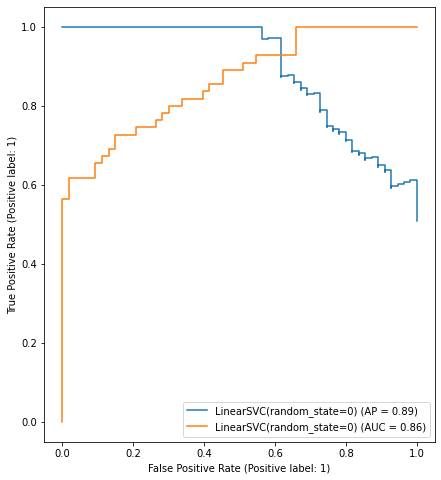

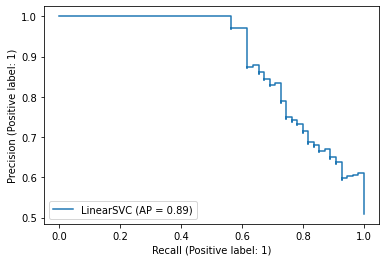

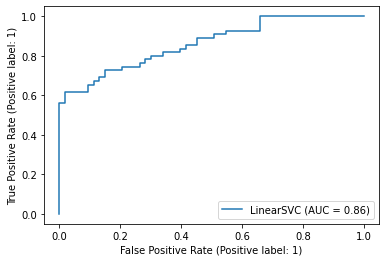

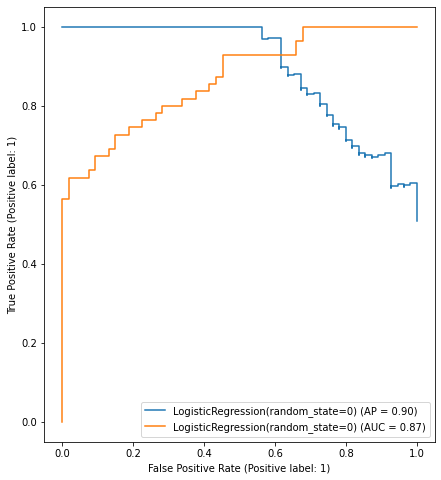

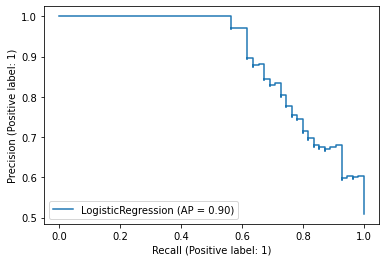

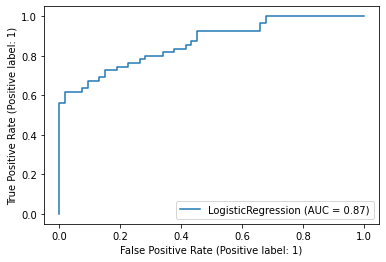

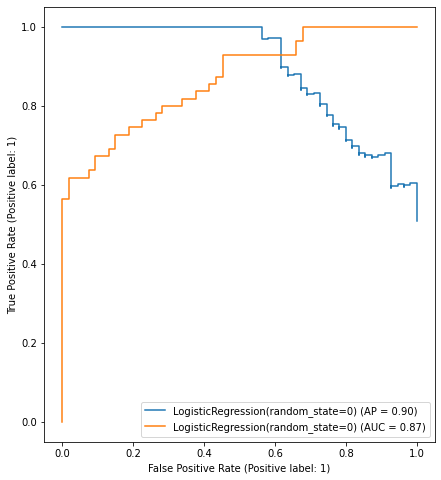

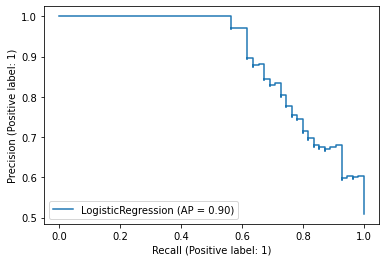

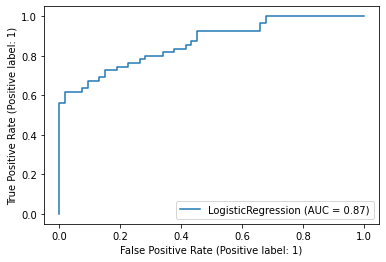

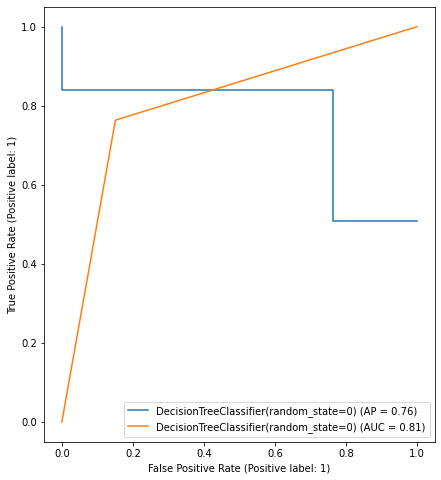

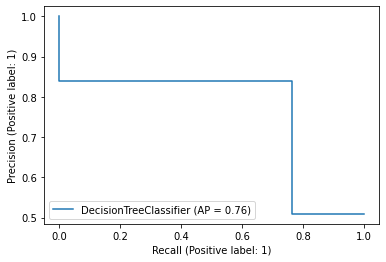

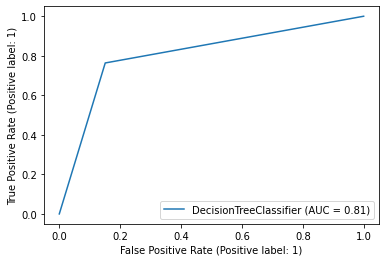

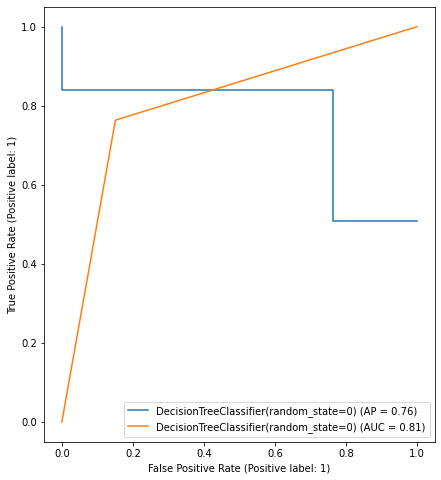

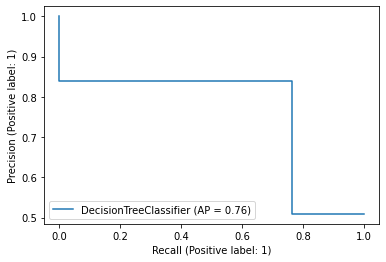

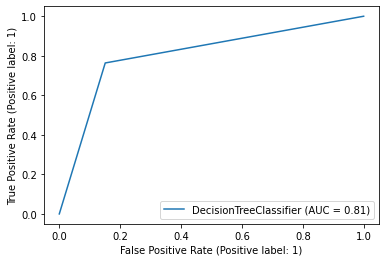

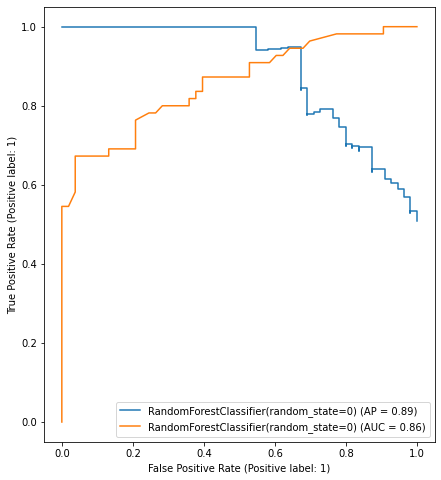

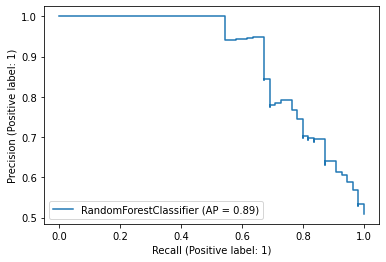

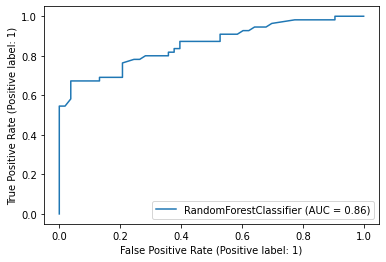

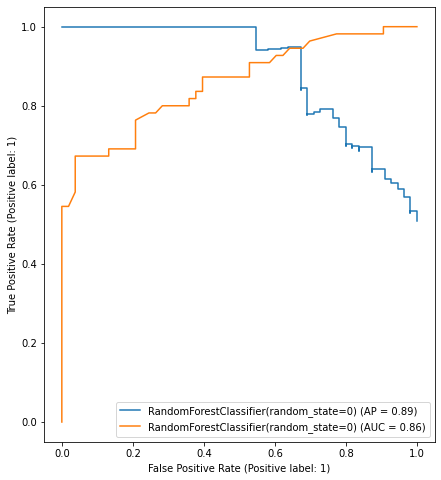

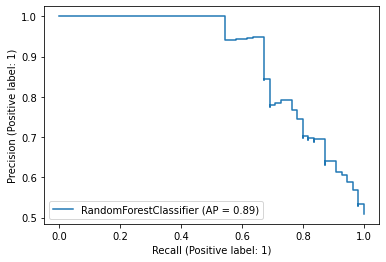

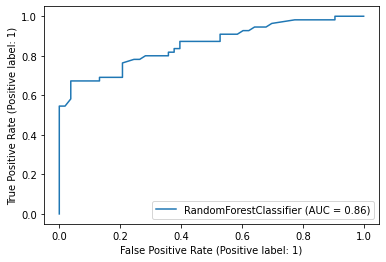

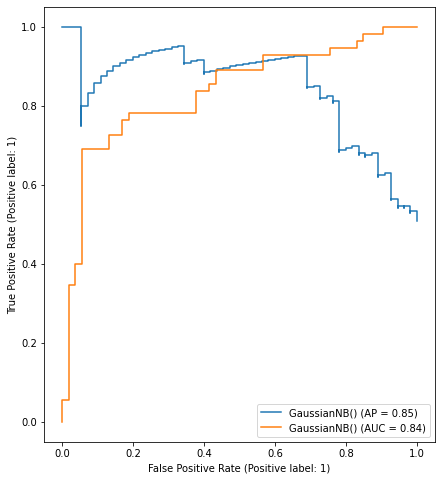

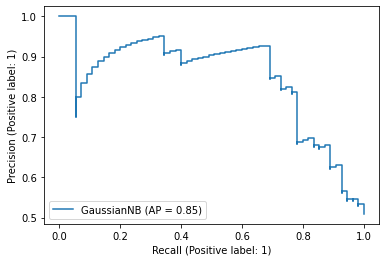

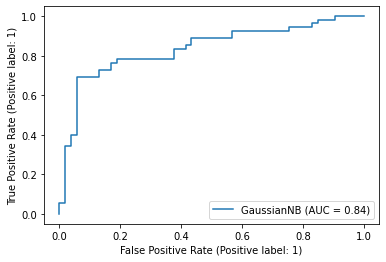

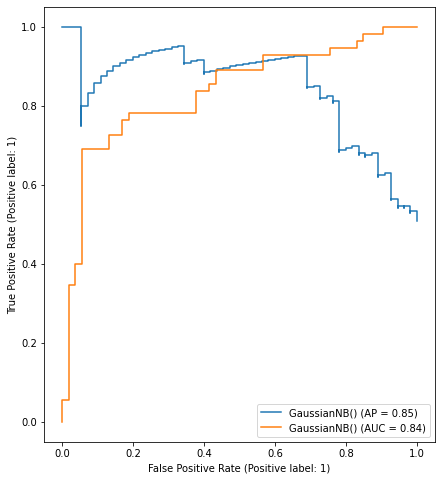

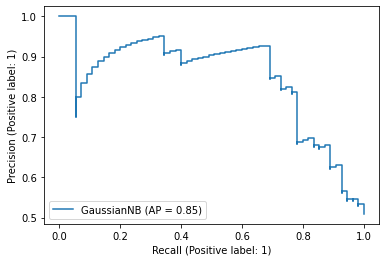

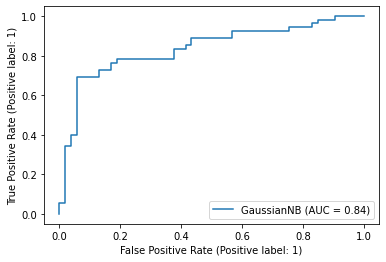

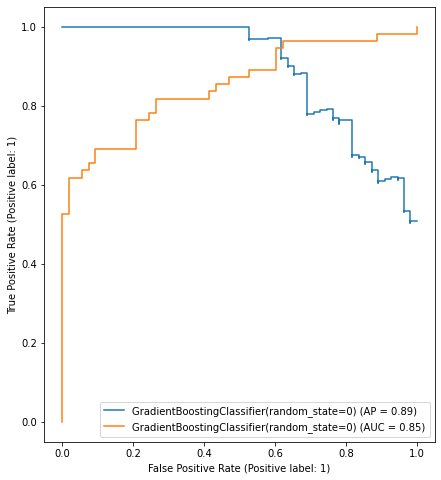

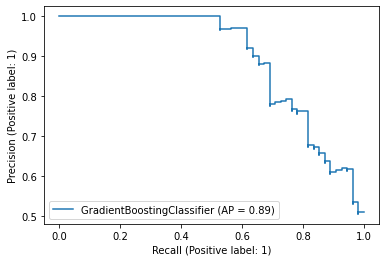

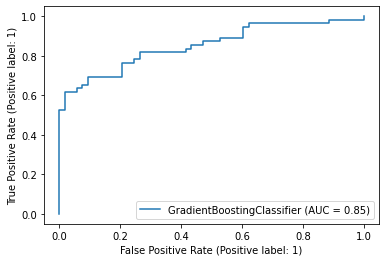

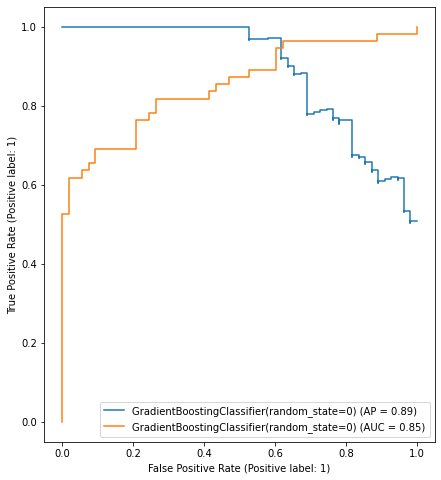

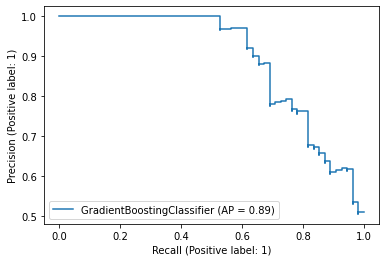

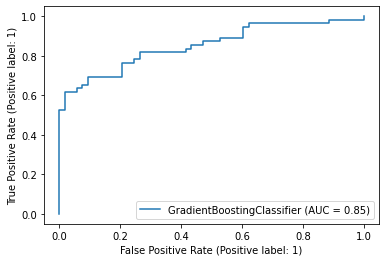

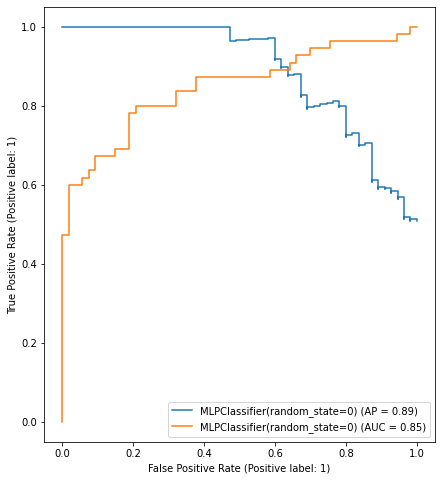

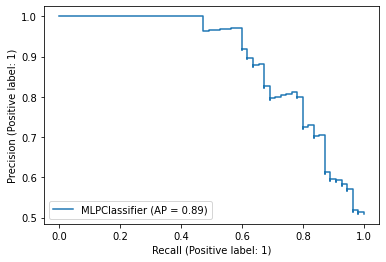

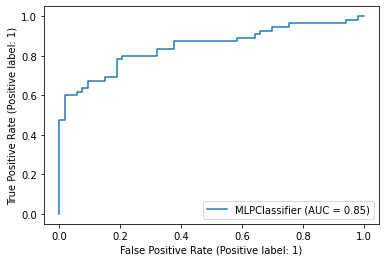

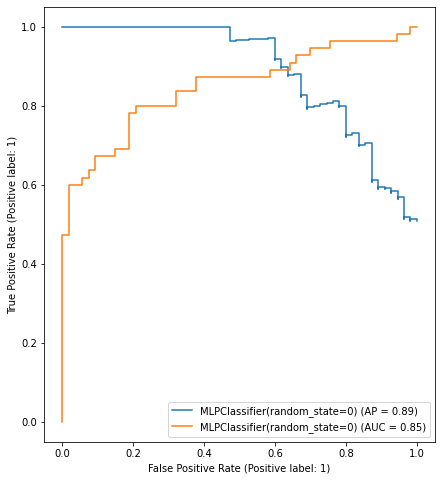

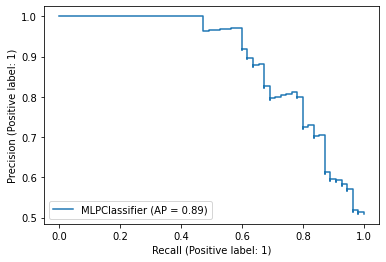

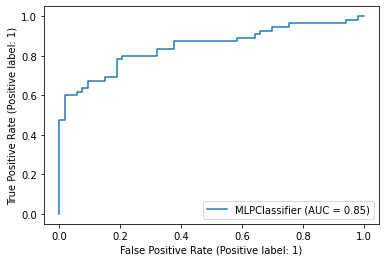

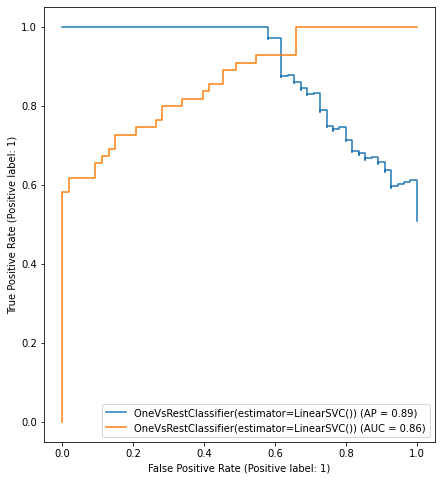

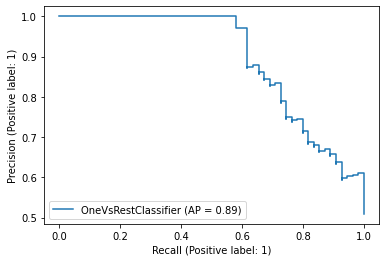

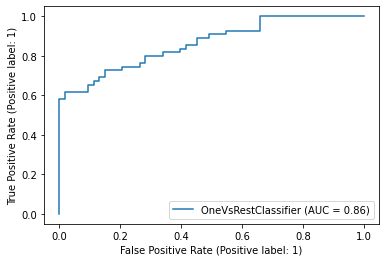

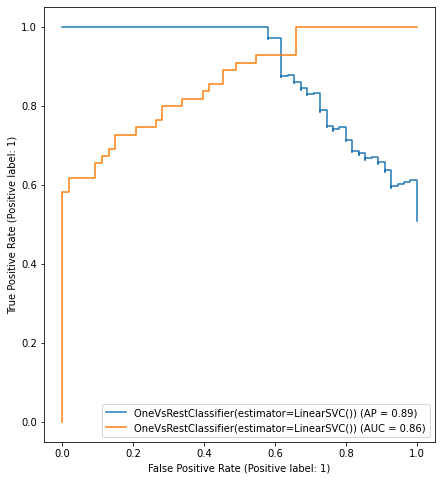

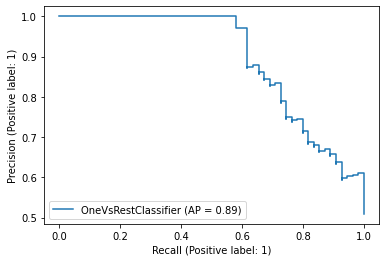

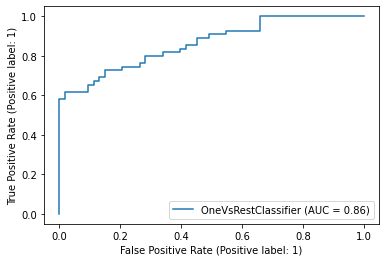

In [27]:
for clf in sklearn_classifiers:
    _, ax = plt.subplots(figsize=(7, 8))
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)
    _, bx = plt.subplots(figsize=(7, 8))
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=bx, name=clf)
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=bx, name=clf)

Hyperparameter tuning
* Select the valid hyperparameters and put them into a Json file 

In [29]:
grid = { 
    "LinearSVC": {
        "max_iter": [10, 50, 100, 500],
        "C": [1, 2, 3, 4],
        "penalty": ["l1", "l2"],
        "loss": ["hinge", "squared_hinge"],
        "fit_intercept": [True, False]},
    "LogisticRegression": {
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "penalty": ["l1", "l2", "elasticnet", "none"],
        "C": [1, 2, 3, 4],
        "max_iter": [10, 50, 100, 500]},
    "DecisionTreeClassifier": {
        "max_depth": [2, 5, 10, 20],
        "min_impurity_decrease": [0, 0.1, 0.2],
        "max_features": [1, 3, 5, 7, 10]},
#         "max_features": [50, 100, 200, 400, 500]},
    "RandomForestClassifier": {
        "max_depth": [2, 5, 10, 20],
        "n_estimators": [5, 10, 50, 100],
        "min_impurity_decrease": [0, 0.1, 0.2],
        "max_features": [1, 3, 5, 7, 10],
#         "max_features": [50, 100, 200, 400, 500],
        "bootstrap": [True, False]},
    "GaussianNB": {
        "var_smoothing": [1e-07, 1e-08, 1e-09, 1e-10]},
    "GradientBoostingClassifier": {
        "max_depth": [2, 5, 10, 20],
        "n_estimators": [5, 10, 50, 100],
        "min_impurity_decrease": [0, 0.1, 0.2],
        "max_features": [1, 3, 5, 7, 10],
#         "max_features": [50, 100, 200, 400, 500],
        "learning_rate": [0.1, 0.01],
        "loss": ["log_loss", "deviance", "exponential"]},
    "MLPClassifier": {
        "hidden_layer_sizes": [(100,), (100,100,), (100,100,50)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "solver": ["lbfgs", "sgd", "adam"],
        "max_iter": [10, 50, 100, 500],
        "learning_rate": ["constant", "invscaling", "adaptive"],
        "batch_size": [8, 32, 128, 512],
        "alpha": [0.001, 0.0001, 0.00001]},
    "OneVsRestClassifier": {
        "n_jobs": [1, 3, 5, 7, 10]}}

Import methods for hyperparameter tuning
* GridSearchCV
* pickle module 

In [32]:
from sklearn.model_selection import GridSearchCV 
import pickle 

Train the models with hyperparameters 

In [ ]:
for clf in sklearn_classifiers:
    rf_cv = GridSearchCV(estimator=clf, param_grid=grid[str(clf)[:str(clf).find("(")]], cv= 5)
    rf_cv.fit(x_train, y_train)
    clf = clf.set_params(**rf_cv.best_params_)
    clf.fit(x_train, y_train)
    if not os.path.exists("./models/sklearn/titanic/"):
        os.makedirs("./models/sklearn/titanic/")
    pickle.dump(clf, open("./models/sklearn/titanic/"+str(clf)[:str(clf).find("(")]+".sav", 'wb'))

    print(clf, rf_cv.best_params_)

LinearSVC(C=4, fit_intercept=False, max_iter=50, random_state=0) {'C': 4, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 50, 'penalty': 'l2'}
LogisticRegression(C=1, max_iter=10, penalty='none', random_state=0,
                   solver='newton-cg') {'C': 1, 'max_iter': 10, 'penalty': 'none', 'solver': 'newton-cg'}
DecisionTreeClassifier(max_depth=2, max_features=5, min_impurity_decrease=0,
                       random_state=0) {'max_depth': 2, 'max_features': 5, 'min_impurity_decrease': 0}
RandomForestClassifier(bootstrap=False, max_depth=2, max_features=3,
                       min_impurity_decrease=0, n_estimators=5, random_state=0) {'bootstrap': False, 'max_depth': 2, 'max_features': 3, 'min_impurity_decrease': 0, 'n_estimators': 5}
GaussianNB(var_smoothing=1e-07) {'var_smoothing': 1e-07}
